# Imports and define functions

In [26]:
import numpy as np
import pandas as pd
import pandas_datareader as dr
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

from time import strftime
from collections import OrderedDict
from scipy.stats import skewtest, kurtosistest, skew, kurtosis
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox, acorr_breusch_godfrey
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.gridspec as gridspec
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define Mean Absolute Percentage Error
def printMAEpred(y_true, y_pred, horizonSteps):
    ae  = abs(y_pred - y_true.T);
    ape = 100*(abs(y_pred - y_true.T) / y_true.T);
    for i in horizonSteps:
        print('Prediction for ' + str(i) + ' step: MAE = ' + str(round(np.mean(ae[0,:i]), 2)) + ' (' + str(round(np.mean(ape[0,:i]), 2)) + '%)'  )

In [3]:
# Evaluate combinations of p, d and q values for a SARIMA model
def SARIMA_grid(dataset, sarimaCfg, isLog):
    df_IC = pd.DataFrame(columns=['SARIMA(p,d,q)t(P,D,Q,m)', 'AIC', 'BIC', 'HQIC'])
    df_IC = df_IC.set_index('SARIMA(p,d,q)t(P,D,Q,m)')
    dict_sarimaFit  = {} 
    dict_sarimaPred = {}
    modelNum = 0;
    totalModelNum = len(sarimaCfg.p_range)*len(sarimaCfg.d_range)*len(sarimaCfg.q_range)*len(sarimaCfg.t_range)* \
                        len(sarimaCfg.P_range)*len(sarimaCfg.D_range)*len(sarimaCfg.Q_range)*len(sarimaCfg.m_range)
    for p in sarimaCfg.p_range:
        for d in sarimaCfg.d_range:
            for q in sarimaCfg.q_range:
                order = (p,d,q)
                for t in sarimaCfg.t_range:
                    for P in sarimaCfg.P_range:
                        for D in sarimaCfg.D_range:
                            for Q in sarimaCfg.Q_range:
                                for m in sarimaCfg.m_range:
                                    seasonal_order = (P,D,Q,m)
                                    modelNum+=1;
                                    print("%d/%d " % (modelNum, totalModelNum))
                                    try:
                                        model = SARIMAX(dataset, order=order, \
                                                                 trend=t,     \
                                                                 seasonal_order=seasonal_order);
                                        model_fit = model.fit(disp=0);

                                        model_str = 'SARIMA' + str(order) + str(t) + str(seasonal_order)
                                        df_IC = df_IC.append(pd.DataFrame({'AIC':model_fit.aic, 'BIC':model_fit.bic, \
                                                                           'HQIC':model_fit.hqic}, index =[model_str]), ignore_index=False)

                                        if (isLog):
                                            dict_sarimaFit[model_str]  = np.e**(model_fit.predict(typ='levels'));
                                            dict_sarimaPred[model_str] = np.e**(model_fit.forecast(steps=stepsToForecast[-1]));
                                        else:
                                            dict_sarimaFit[model_str]  = model_fit.predict(typ='levels');
                                            dict_sarimaPred[model_str] = model_fit.forecast(steps=stepsToForecast[-1]);
                                    except:
                                        continue
    return dict_sarimaFit, dict_sarimaPred, df_IC

In [4]:
def replaceInitialOutliers(df, numInitialSamples, valToReplace, outlierConstant):
    df_resNew = df.copy()
    upper_quartile = np.percentile(df_resNew.values, 75)
    lower_quartile = np.percentile(df_resNew.values, 25)
    
    # Interquantile Range
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    lower_quartileBound = lower_quartile - IQR
    upper_quartileBound = upper_quartile + IQR
    
    outliers = []
    for ix in range(0, numInitialSamples):
        if (df_resNew.values[ix] < lower_quartileBound or df_resNew.values[ix] > upper_quartileBound):
            outliers.append((df_res.index[ix].strftime("%Y-%m-%d"), df_res.values[ix][0]))
            df_resNew.values[ix] = valToReplace
            
    return df_resNew, outliers

## Import Data

In [5]:
# df = Dataframe with an index and a value column
# title = Title of data being used
# xlab = Label of df.index
# ylab = Label of df.values
# seasonal_periods = The repetition cycle

previousStepsToShow = 15;

stepsToForecast = [1, 3, 12]
df = dr.DataReader("TRFVOLUSM227NFWA", "fred", start="1947-01-01", end="2019-09-01")
df_train = df[['TRFVOLUSM227NFWA']][:-stepsToForecast[-1]].rename(columns={'TRFVOLUSM227NFWA': 'train'})
df_test = df[['TRFVOLUSM227NFWA']][-stepsToForecast[-1]:].rename(columns={'TRFVOLUSM227NFWA': 'test'})
title = "Vehicle Miles Traveled";
xlab = "Months/Year";
ylab = "Millions of Miles";
seasonal_periods = 12

# Assess Stationarity of the Time-Series

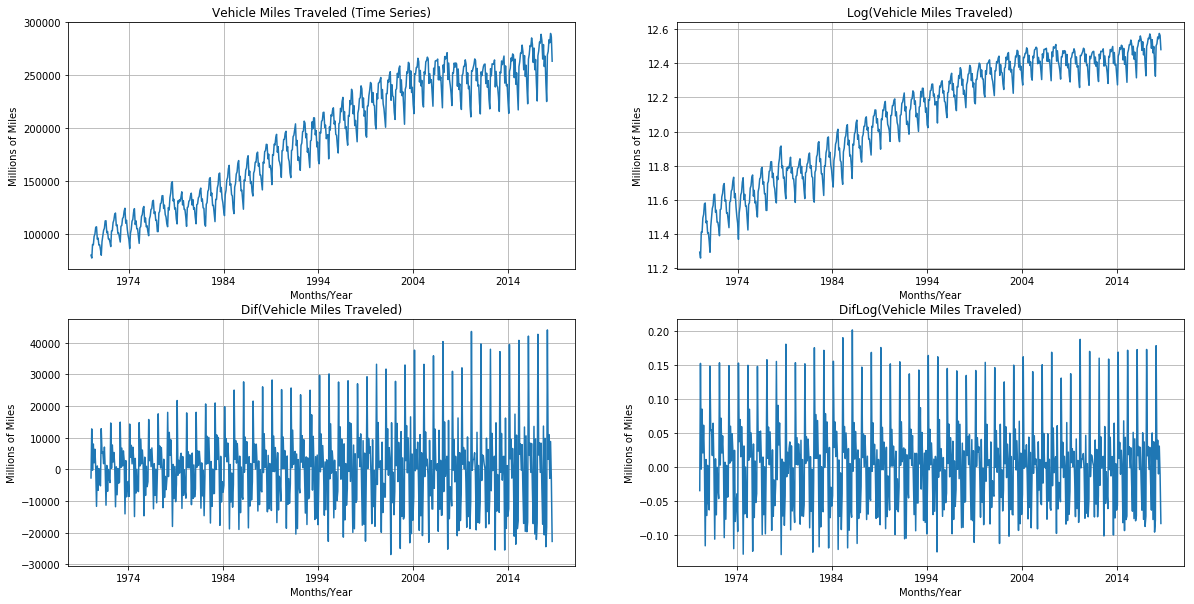

In [7]:
# In order to achieve stationarity, it is common to use Log transformations
# Transformations such as logarithms can help to stabilise the variance of a time series. 
# Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, 
#and therefore eliminating (or reducing) trend and seasonality.
fig = plt.figure(figsize=(20,10))

fig.add_subplot(221)
plt.title(title + ' (Time Series)')
plt.plot(df_train)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(222)
plt.title('Log(' + title + ')')
plt.plot(np.log(df_train))
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(223)
plt.title('Dif(' + title + ')')
plt.plot(df_train.diff().dropna())
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(224)
plt.title('DifLog(' + title + ')')
plt.plot(np.log(df_train).diff().dropna())
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

plt.show()

In [8]:
# Jarque-Bera goodness of fit test on sample data
# Tests if the sample data has the skewness and kurtosis matching a normal distribution
jb, jbpval = stats.jarque_bera(df_train)
print("Jarque-Bera Test for " + title)
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(np.log(df_train))
print("Jarque-Bera Test for Log(" + title + ")")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(df_train.diff().dropna())
print("Jarque-Bera Test for Diff(" + title + ")")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(np.log(df_train).diff().dropna())
print("Jarque-Bera Test for Diff(Log(" + title + "))")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval) 
print("")

Jarque-Bera Test for Vehicle Miles Traveled
Statistic: 46.4422
p-value: 0.0000

Jarque-Bera Test for Log(Vehicle Miles Traveled)
Statistic: 49.2915
p-value: 0.0000

Jarque-Bera Test for Diff(Vehicle Miles Traveled)
Statistic: 71.9418
p-value: 0.0000

Jarque-Bera Test for Diff(Log(Vehicle Miles Traveled))
Statistic: 40.9344
p-value: 0.0000



In [9]:
# Kolmogorov-Smirnov Test goodness of fit test on sample data
ks, kspval = stats.kstest(df_train.values, 'norm')
print("Kolmogorov-Smirnov Test")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)  
print("")
ks, kspval = stats.kstest(np.log(df_train), 'norm')
print("Kolmogorov-Smirnov Test for Log(" + title + ")")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)
print("")
ks, kspval = stats.kstest(df_train.diff().dropna(), 'norm')
print("Kolmogorov-Smirnov Test for Diff(" + title + ")")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)
print("")
ks, kspval = stats.kstest(np.log(df_train).diff().dropna(), 'norm')
print("Kolmogorov-Smirnov Test for Diff(Log(" + title + "))")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval) 
print("")

Kolmogorov-Smirnov Test
Statistic: 1.0000
p-value: 0.0000

Kolmogorov-Smirnov Test for Log(Vehicle Miles Traveled)
Statistic: 1.0000
p-value: 0.0000

Kolmogorov-Smirnov Test for Diff(Vehicle Miles Traveled)
Statistic: 1.0000
p-value: 0.0000

Kolmogorov-Smirnov Test for Diff(Log(Vehicle Miles Traveled))
Statistic: 0.5801
p-value: 0.0000



In [10]:
# The Augmented Dickey-Fuller test 
# Used to test for a unit root in a univariate process in the presence of serial correlation.
result = adfuller(df_train['train'].values)
print("Augmented Dickey Fuller Test for " + title)
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))
print("")
result = adfuller(np.log(df_train['train'].values))
print("Augmented Dickey Fuller Test for Log(" + title + ")")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))
print("")
result = adfuller(df_train['train'].diff().dropna())
print("Augmented Dickey Fuller Test for Diff(" + title + ")")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print ("\t%s: %.3f" % (key, value))
print("")
result = adfuller(np.log(df_train['train']).diff().dropna().values)
print("Augmented Dickey Fuller Test for Diff(Log(" + title + "))")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))

Augmented Dickey Fuller Test for Vehicle Miles Traveled
Statistic: -1.3019
p-value: 0.6283
Used lags: 17
Num obs: 567
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569

Augmented Dickey Fuller Test for Log(Vehicle Miles Traveled)
Statistic: -3.1145
p-value: 0.0255
Used lags: 14
Num obs: 570
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569

Augmented Dickey Fuller Test for Diff(Vehicle Miles Traveled)
Statistic: -4.8396
p-value: 0.0000
Used lags: 16
Num obs: 567
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569

Augmented Dickey Fuller Test for Diff(Log(Vehicle Miles Traveled))
Statistic: -4.7485
p-value: 0.0001
Used lags: 16
Num obs: 567
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569


In [11]:
# Kwiatkowski-Phillips-Schmidt-Shin
# Test for level or trend stationarity
result = kpss(df_train['train'].values)
print("KPSS Test for " + title)
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(np.log(df_train['train'].values))
print("KPSS Test for Log(" + title + ")")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(df_train['train'].diff().dropna())
print("KPSS Test for Diff(" + title + ")")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(np.log(df_train['train']).diff().dropna().values)
print("KPSS Test for Diff(Log(" + title + "))")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));

KPSS Test for Vehicle Miles Traveled
Statistic: 3.0054
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

KPSS Test for Log(Vehicle Miles Traveled)
Statistic: 2.9389
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

KPSS Test for Diff(Vehicle Miles Traveled)
Statistic: 0.0418
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

KPSS Test for Diff(Log(Vehicle Miles Traveled))
Statistic: 0.1216
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347


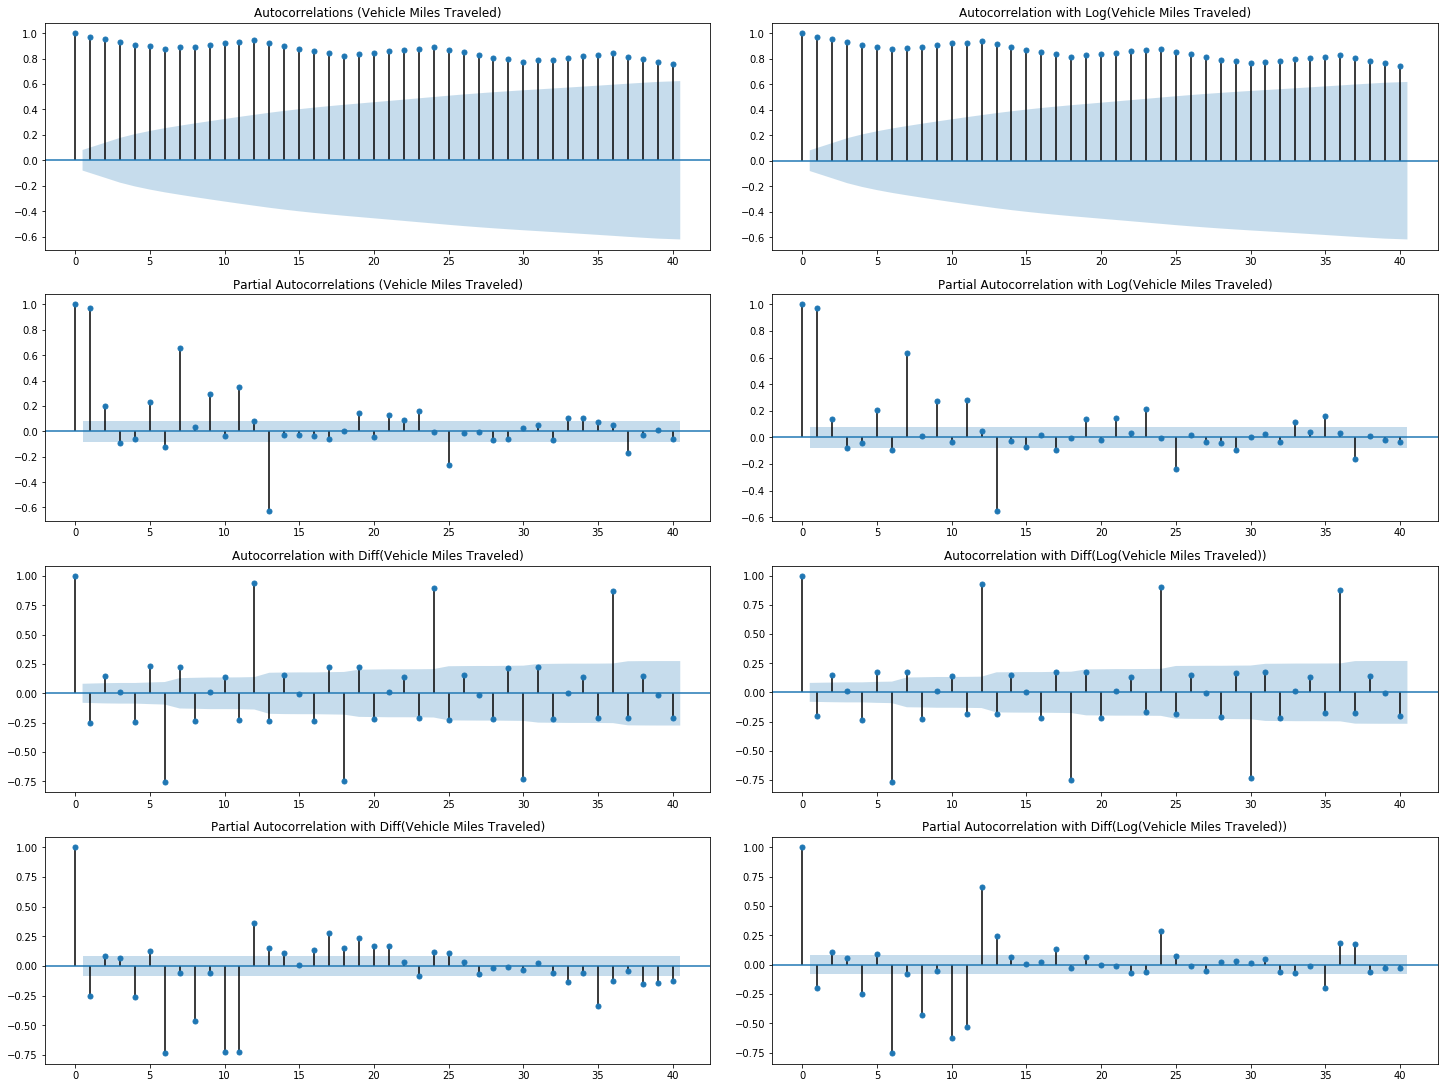

In [12]:
# Correlation plots
# These plots are useful for identifying non-stationary time series 

# This also gives an idea of the order of the model by:
# AR(p) - p from the partial autocorrelation plot
# I(d)  - d from the number of Diffs your dataset is using
# MA(q) - q from the autocorrelation plot

maxLags = 40

fig = plt.figure(figsize=(20,15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=4, figure=fig)

# Auto-correlation function for original time series
ax_acf = fig.add_subplot(spec[0, 0])
sm.graphics.tsa.plot_acf(df_train, lags=maxLags, ax=ax_acf, title='Autocorrelations (' + title + ')')
# Partial auto-correlation function for original time series
ax_pacf = fig.add_subplot(spec[1, 0])
sm.graphics.tsa.plot_pacf(df_train, lags=maxLags, ax=ax_pacf, title='Partial Autocorrelations (' + title + ')');

# Auto-correlation function for time series transformed with Log
ax_acfLog = fig.add_subplot(spec[0, 1])
sm.graphics.tsa.plot_acf(np.log(df_train), lags=maxLags, ax=ax_acfLog, title='Autocorrelation with Log('+ title + ')')
# Partial auto-correlation function for time series transformed with Log
ax_pacfLog = fig.add_subplot(spec[1, 1])
sm.graphics.tsa.plot_pacf(np.log(df_train), lags=maxLags, ax=ax_pacfLog, title='Partial Autocorrelation with Log('+ title + ')');

# Auto-correlation function for time series transformed with Diff
ax_acfDiff = fig.add_subplot(spec[2, 0])
sm.graphics.tsa.plot_acf(df_train.diff().dropna(), lags=maxLags, ax=ax_acfDiff, title='Autocorrelation with Diff('+ title + ')')
# Partial auto-correlation function for time series transformed with Diff
ax_pacfDiff = fig.add_subplot(spec[3, 0])
sm.graphics.tsa.plot_pacf(df_train.diff().dropna(), lags=maxLags, ax=ax_pacfDiff, title='Partial Autocorrelation with Diff('+ title + ')');

# Auto-correlation function for time series transformed with Log
ax_acfDiffLog = fig.add_subplot(spec[2, 1])
sm.graphics.tsa.plot_acf(np.log(df_train).diff().dropna(), lags=maxLags, ax=ax_acfDiffLog, title='Autocorrelation with Diff(Log('+ title + '))')
# Partial auto-correlation function for time series transformed with Log
ax_pacfDiffLog = fig.add_subplot(spec[3, 1])
sm.graphics.tsa.plot_pacf(np.log(df_train).diff().dropna(), lags=maxLags, ax=ax_pacfDiffLog, title='Partial Autocorrelation with Diff(Log('+ title + '))');

In [7]:
# From now on, we must choose whether we go with the Log(Time-Series) or not
# This should be done to remove stationarity of the data, so that ARIMA works
# In addition, if the model is multiplicative we need to use log to make it additive
#as ARIMA relies on that assumption

# The previously seen differentiated data enters in the I component of the ARIMA model
#it will take care of differenciating for us

#df_Train = df_train
#isLog = False

df_Train = pd.DataFrame(np.log(df_train), index = df_train.index)
isLog = True

## Run different SARIMA models combinations

In [14]:
# Range of SARIMA models to compute
class sarimaCfg:
    p_range = range(1, 5) # [1,8)
    d_range = range(1, 2) # [1,3)
    q_range = range(1, 5) # [1,8)
    t_range = ['n', 'c']
    P_range = range(1, 3) # [1,8)
    D_range = range(1, 2) # [1,3)
    Q_range = range(1, 3) # [1,8)
    m_range = range(12, 13) # [1,3) 

dict_sarimaFit, dict_sarimaPred, df_IC = SARIMA_grid(df_Train.values, sarimaCfg, isLog)
#dict_sarimaFit, dict_sarimaPred, df_IC

1/1 


## Model Selection

In [ ]:
print(df_IC[['AIC']].sort_values('AIC').head().rename(columns={'AIC': 'TOP 5 AIC'}))
print(" ")
print(df_IC[['BIC']].sort_values('BIC').head().rename(columns={'BIC': 'TOP 5 BIC'}))
print(" ")
print(df_IC[['HQIC']].sort_values('HQIC').head().rename(columns={'HQIC': 'TOP 5 HQIC'}))

## Forecast

In [ ]:
# Select models to evaluate
labels = ['Real Closing price',
          'SARIMA(1, 1, 4)n(1, 1, 2, 12)',
          'SARIMA(1, 1, 4)n(2, 1, 1, 12)',
          'SARIMA(1, 1, 4)n(2, 1, 2, 12)',
          'SARIMA(1, 1, 1)n(1, 1, 2, 12)',
          'SARIMA(1, 1, 1)n(1, 1, 1, 12)',
          'SARIMA(1, 1, 1)n(2, 1, 1, 12)']

In [ ]:
# Model selection comparison
plt.figure(figsize=(20,5))

params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)

# set width of bar
spacing = 0.05
barWidth = 0.025
r = np.arange(3) - ((len(labels)-1)/2)*spacing

for i in np.arange(len(labels)-1):
    plt.bar(r, df_IC.loc[labels[i+1]].values, width=barWidth, edgecolor='white', label=labels[i+1])
    r = [x + spacing for x in r]
 
plt.xticks([r + barWidth for r in range(3)], ['AIC', 'BIC', 'HQIC'], fontsize='20')
plt.axis((-0.5, 3.0, min(df_IC.min())-0.05*(max(df_IC.max())-min(df_IC.min())), max(df_IC.max())+0.05*(max(df_IC.max())-min(df_IC.min()))))
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
# plot results
plt.figure(figsize=(20,7))
previousStepsToShow = 15;
plt.title(title + ' fitting and forecasting')
plt.plot(1+np.arange(stepsToForecast[-1]), df_test.values, 'k-o' , linewidth = 3 )
for i in np.arange(len(labels)-1):
    sarimaPlot = plt.plot(1+np.arange(stepsToForecast[-1]), dict_sarimaPred[labels[i+1]], '--*' , linewidth = 3, label = labels[i+1] )
    plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, dict_sarimaFit[labels[i+1]][-previousStepsToShow:], '--' , linewidth = 2, color=sarimaPlot[0].get_color())
plt.legend(loc='upper left', framealpha=0.95)
plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, df_train.values[-previousStepsToShow:], 'k', linewidth = 4 )
plt.grid(color='k', linestyle='--', linewidth=.2)
plt.xlim([1-previousStepsToShow,+stepsToForecast[-1]])
plt.xticks(1+np.arange(-previousStepsToShow, stepsToForecast[-1]))
plt.xlabel('Past and future samples')
plt.ylabel(ylab);

In [ ]:
for i in np.arange(len(labels)-1):
    print(labels[i+1])
    printMAEpred(df_test.values, dict_sarimaPred[labels[i+1]], stepsToForecast)
    print("")

# Model Validation

In [27]:
# Pick you favourite's models order
order = (1, 1, 4)
trend = 'n'
seasonal_order= (1, 1, 1, 3)

model = SARIMAX(df_Train.values, order=order, trend=trend, seasonal_order=seasonal_order)
model_fit = model.fit(disp=0);
df_res = pd.DataFrame({"resid": model_fit.resid}, index= df_Train.index)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  585
Model:             SARIMAX(1, 1, 4)x(1, 1, 1, 3)   Log Likelihood                 893.197
Date:                           Sun, 19 Jan 2020   AIC                          -1770.393
Time:                                   20:01:07   BIC                          -1735.475
Sample:                                        0   HQIC                         -1756.781
                                           - 585                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7356      0.053    -13.971      0.000      -0.839      -0.632
ma.L1          0.7298      0.034     21.392      0.000       0.663       0.797
ma.L2         -0.0944      0.031     -3.088      0.002      -0.154      -0.034
ma.L3         -0.7524      0.036    -20.720      0.000      -0.824      -0.681
ma.L4         -0.8218      0.032    -25.462      0.000      -0.885      -0.759
ar.S.L3        0.1000      0.065      1.536      0.125      -0.028       0.228
ma.S.L3       -0.9269      0.037    -24.888      0.000      -1.000      -0.854
sigma2         0.0026      0.000     12.097      0.000       0.002       0.003
===================================================================================
Ljung-Box (Q):                     2114.12   Jarque-Bera (JB):                17.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.21
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

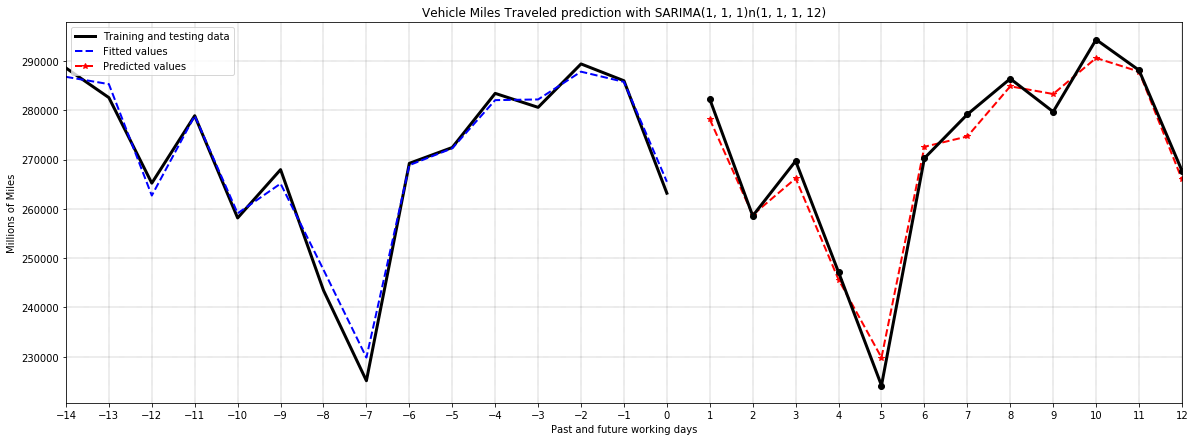

In [23]:
plt.figure(figsize=(20,7))
labels = ['Training and testing data', 'Fitted values', 'Predicted values']
plt.title(title + " prediction with SARIMA" + str(order) + str(trend) + str(seasonal_order))
plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, df_train.values[-previousStepsToShow:], 'k', linewidth = 3 )
plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, dict_sarimaFit[ 'SARIMA' + str(order) + str(trend) + str(seasonal_order)][-previousStepsToShow:], 'b--' , linewidth = 2)
plt.plot(1+np.arange(stepsToForecast[-1]), dict_sarimaPred['SARIMA' + str(order) + str(trend) + str(seasonal_order)], 'r--*' , linewidth = 2)
plt.plot(1+np.arange(stepsToForecast[-1]), df_test.values, 'k-o' , linewidth = 3 )
plt.legend(labels, loc='upper left')
plt.grid(color='k', linestyle='--', linewidth=.2)
plt.xlim([1-previousStepsToShow, stepsToForecast[-1]])
plt.xticks(1+np.arange(-previousStepsToShow, stepsToForecast[-1]))
plt.xlabel('Past and future working days')
plt.ylabel(ylab)
plt.show()

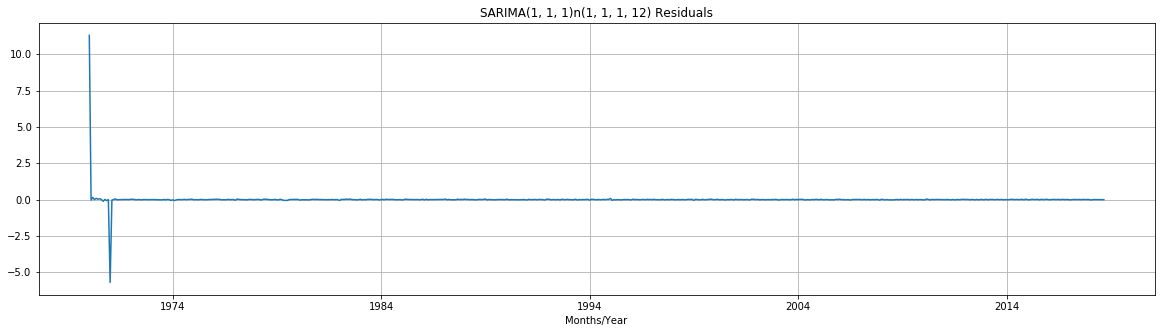

In [9]:
# Plot model residuals
plt.figure(figsize=(20,5))
plt.plot(df_res.index, df_res.values)
plt.xlabel(xlab)
plt.title('SARIMA' + str(order) + trend + str(seasonal_order) + ' Residuals')
plt.grid()

The following plot results from the residuals depicted above by replacing: 
1970-01-01: 11.2919 to 0.0000
1970-04-01: -5.6489 to 0.0000


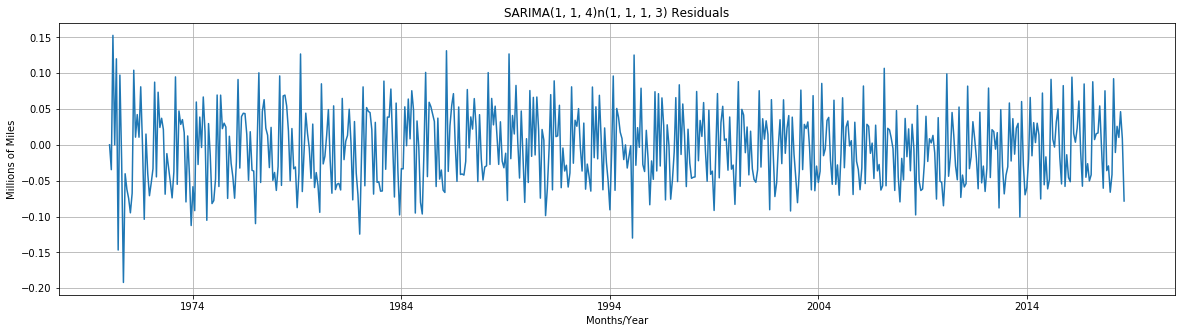

In [28]:
# Clearly there are outliers at the beggining, in order to not interfere with our residual analysis 
#we will find these with an IQR algorithm applied at the beggining of the time series and replace by 0
df_resNew, outliers = replaceInitialOutliers(df_res, seasonal_periods*5, 0, 3.5)

print("The following plot results from the residuals depicted above by replacing: ")
for key, value in outliers:
    print("%s: %.4f to 0.0000" % (key, value));

plt.figure(figsize=(20,5))
plt.plot(df_resNew.index, df_resNew.values)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.title('SARIMA' + str(order) + trend + str(seasonal_order) + ' Residuals')
plt.grid()

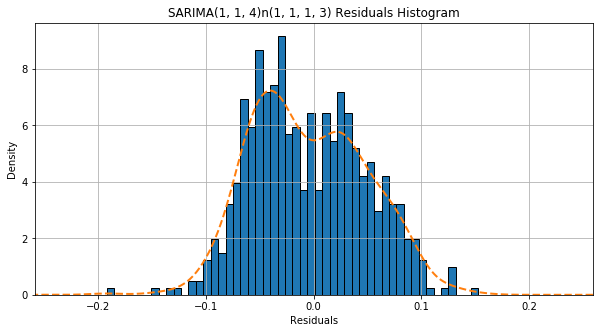

In [29]:
# Plot histogram
plt.figure(figsize=(10,5))
plt.title('SARIMA' + str(order) + trend + str(seasonal_order) + ' Residuals Histogram')
hist_res = df_resNew['resid'].hist(bins=50, normed=1, edgecolor='black')
df_resNew['resid'].plot(kind='kde', linewidth=2, linestyle='--')
#plt.text(np.std(df_resNew.values), hist_res.get_ylim()[1]*0.8, r'$\mu = $'+ str(round(np.mean(df_resNew), 6)))
#plt.text(np.std(df_resNew.values), hist_res.get_ylim()[1]*0.75, r'$\sigma^2 = $' + str(round(np.var(df_resNew), 6)))
plt.xlabel('Residuals')
limX = np.mean(df_resNew.values)+5*np.std(df_resNew.values);
plt.xlim((-limX, limX))
plt.grid()
plt.show()

In [ ]:
print ("Mean: %.6f" % np.mean(df_resNew))
print ("Variance: %.6f" % np.var(df_resNew))

## Normality Test

In [ ]:
k, kpval = kurtosistest(df_resNew['resid'].values)
kurtosis_val = kurtosis(df_resNew['resid'].values, fisher=True)
# If Fisher’s definition is used, then 3.0 is subtracted from the result to give 0.0 for a normal distribution.
print("Kurtosis Test")
print("Statistic: %.4f" % k)
print("p-value: %.4f" % kpval)
print("Kurtosis value: %.4f" % kurtosis_val)
print(" ")

s, spval = skewtest(df_resNew['resid'].values)
skew_val = skew(df_resNew['resid'].values)
print("Skew Test")
print("Statistic: %.4f" % s)
print("p-value: %.4f" % spval) 
print("Skewness value: %.4f" % skew_val) 
print(" ")

jb, jbpval= stats.jarque_bera(df_resNew['resid'].values)
print("Jarque-Bera Test")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print(" ")

ks, kspval = stats.kstest(df_resNew['resid'].values, 'norm')
print("Kolmogorov-Smirnov Test")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval) 

### Engle\'s Test for Autoregressive Conditional Heteroscedasticity (ARCH)

In [18]:
lm, lmpval, fval, fpval = het_arch(df_resNew['resid'].values)
print('Lagrange multiplier test statistic')
print("LM Statistic: %.4f" % lm)
print("LM-Test p-value: %.4f" % lmpval)
print('')

print('fstatistic for F test')
print("F Statistic: %.4f" % fval)
print("F-Test p-value: %.4f" % fpval)
print('')

Lagrange multiplier test statistic
LM Statistic: 49.9076
LM-Test p-value: 0.0001

fstatistic for F test
F Statistic: 2.7789
F-Test p-value: 0.0001



### Test for No Autocorrelation

#### Brock–Dechert–Scheinkman test

In [30]:
# Computing BDS
# Tests independent and identically distributed (i.i.d.) time series
result = bds(df_resNew['resid'].values, max_dim=6);
print("BDS Test")
print("Dim 2: z-static %.4f Prob %.4f" % (result[0][0], result[1][0]))
print("Dim 3: z-static %.4f Prob %.4f" % (result[0][1], result[1][1]))
print("Dim 4: z-static %.4f Prob %.4f" % (result[0][2], result[1][2]))
print("Dim 5: z-static %.4f Prob %.4f" % (result[0][3], result[1][3]))
print("Dim 6: z-static %.4f Prob %.4f" % (result[0][4], result[1][4]))

BDS Test
Dim 2: z-static -1.9570 Prob 0.0503
Dim 3: z-static -0.3463 Prob 0.7291
Dim 4: z-static -0.5190 Prob 0.6038
Dim 5: z-static 1.2557 Prob 0.2092
Dim 6: z-static 2.0648 Prob 0.0389


#### Box-Pierce test

In [ ]:
maxLags = 21
lbvalue, pvalue, bpvalue, bppvalue = acorr_ljungbox(df_resNew['resid'].values, lags = range(1, maxLags), boxpierce=True)
df_boxpierce = pd.DataFrame({'lags':range(1, maxLags), 'bp statistic': bpvalue, 'p-value':bppvalue})
print(df_boxpierce[['lags', 'bp statistic', 'p-value']].to_string(index = False))

#### Ljung-Box test

In [ ]:
df_ljungbox = pd.DataFrame({'lags':range(1, maxLags), 'lb statistic': bpvalue, 'p-value':pvalue})
print(df_ljungbox[['lags', 'lb statistic', 'p-value']].to_string(index = False))

In [ ]:
qqplot(df_resNew['resid'].values, stats.t, fit=True, line='45')
plt.title('QQ plot');
plt.grid()

In [ ]:
fig = plt.figure(figsize=(20,10))

# Auto-correlation function
ax1 = fig.add_subplot(221)
ax1.grid()
sm.graphics.tsa.plot_acf(df_resNew['resid'].values, lags=maxLags, ax=ax1)
ax2 = fig.add_subplot(222)
ax2.grid()
sm.graphics.tsa.plot_acf(df_resNew['resid'].values, lags=maxLags, ax=ax2, title = 'Zoom Autocorrelation')
ax2.axis((0, maxLags, -0.2, 0.2))

# Partial auto-correlation function
ax3 = fig.add_subplot(223)
ax3.grid()
sm.graphics.tsa.plot_pacf(df_resNew['resid'].values, lags=maxLags, ax=ax3);
ax4 = fig.add_subplot(224)
ax4.grid()
sm.graphics.tsa.plot_pacf(df_resNew['resid'].values, lags=maxLags, ax=ax4, title = 'Zoom Partial Autocorrelation')
ax4.axis((0, maxLags, -0.2, 0.2));